# Visualisation des features d'un CNN par optimisation à partir de bruit

In [1]:
from pathlib import Path
from datetime import datetime as dt

import cv2
import scipy
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense
from keras import applications
from keras.layers import Input
from keras import backend as K

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
def preprocess_noise(x):
    return (x - x.mean()) / x.std()

def postprocess_noise(x):
    x = x.copy()

    x = (x - x.mean()) / x.std()
    x = ((x * 0.1) + 0.5)
    x = np.clip(x, 0, 1)
    
    x = x * 255
    x = x[:, :, ::-1].astype("uint8")
    
    return x

def imshow(imgs, titles=None, n_cols=5, figsize=(10, 10)):
    if len(imgs) == 1:
        plt.figure(figsize=figsize)
        plt.imshow(imgs[0])
        plt.axis('off')
        return
    
    n_cols = min(len(imgs), n_cols)
    n_rows = (len(imgs) // n_cols)
    
    if len(imgs) > n_cols * n_rows:
        n_rows += 1
    
    f, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    titles = titles if titles is not None else [""] * len(imgs)
    
    for idx, (img, title) in enumerate(zip(imgs, titles)):
        if n_rows == 1:
            ax = axs[idx % n_cols]
        elif n_cols == 1:
            ax = axs[idx % n_rows]
        else:
            ax = axs[idx // n_cols, idx % n_cols]
        
        ax.imshow(img)
        ax.set_title(title)
    
    for ax in axs.flatten():
        ax.set_axis_off()

## Définition du modèle (VGG16) 

In [3]:
img_shape = [224, 224, 3]

dream = Input(shape=img_shape)

model = applications.VGG16(include_top=True, weights="imagenet", input_tensor=dream)

last_layer = model.layers.pop()
custom_predictions = Dense(1000, name="custom_predictions")(model.layers[-1].output)
model = Model(inputs=dream, outputs=custom_predictions)
model.layers[-1].set_weights(last_layer.get_weights())

layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
layers = [layer for layer in layer_dict.keys() if "conv" in layer]

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Définition de la fonction de coût à maximiser et de la procédure d'optimisation

In [4]:
def get_filter_loss_and_grads_function(layer_name, filter_index):
    layer_output = layer_dict[layer_name].output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, dream)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    return K.function([dream], [loss, grads])

def optimize_filter_input(layer_name, filter_index, iterations, step, sigma, decay):
    img = (np.random.random(img_shape) * 255).astype('uint8')
    img = preprocess_noise(img)

    loss_and_grads_function = get_filter_loss_and_grads_function(layer_name, filter_idx)

    for i in range(iterations):
        loss_value, grads_value = loss_and_grads_function([[img]])

        if i == 5 and loss_value <= 1:
            break

        current_step = step - (i * (step / iterations))
        current_sigma = sigma - (i * (sigma / iterations))

        img += current_step * grads_value[0]

        img_blur = cv2.GaussianBlur(img, (3, 3), current_sigma)
        img_decay = img * decay
        img = (img_blur + img_decay) / 2

        # print(f"loss value at {i} = {loss_value:.2f} (step = {current_step:.2f}, sigma = {current_sigma:.2f})")
        
    return img, loss_value

## Optimisation de neurones/filtres

In [5]:
iterations = 50
step = 10.
sigma = 3
decay = 0.9

### Exemples des couches les moins profondes aux plus profondes (plus grand niveau d'abstractions)

In [ ]:
imgs = []
titles = []

np.random.seed(0)

for layer_name in layers:
    
    layer_imgs = []
    layer_titles = []
    
    while len(layer_imgs) < 2:
        filter_idx = np.random.randint(0, layer_dict[layer_name].output.shape.as_list()[-1] - 1)

        print(f"#{len(imgs)+len(layer_imgs)} : {layer_name}_{filter_idx}")

        img, loss_value = optimize_filter_input(layer_name, filter_idx, iterations, step, sigma, decay)

        print(f"loss value = {loss_value:.2f}
        print()

        if loss_value > 1.:
            layer_imgs.append(postprocess_noise(img))
            layer_titles.append(f"{layer_name}_{filter_idx}")
    
    imgs += layer_imgs
    titles += layer_titles

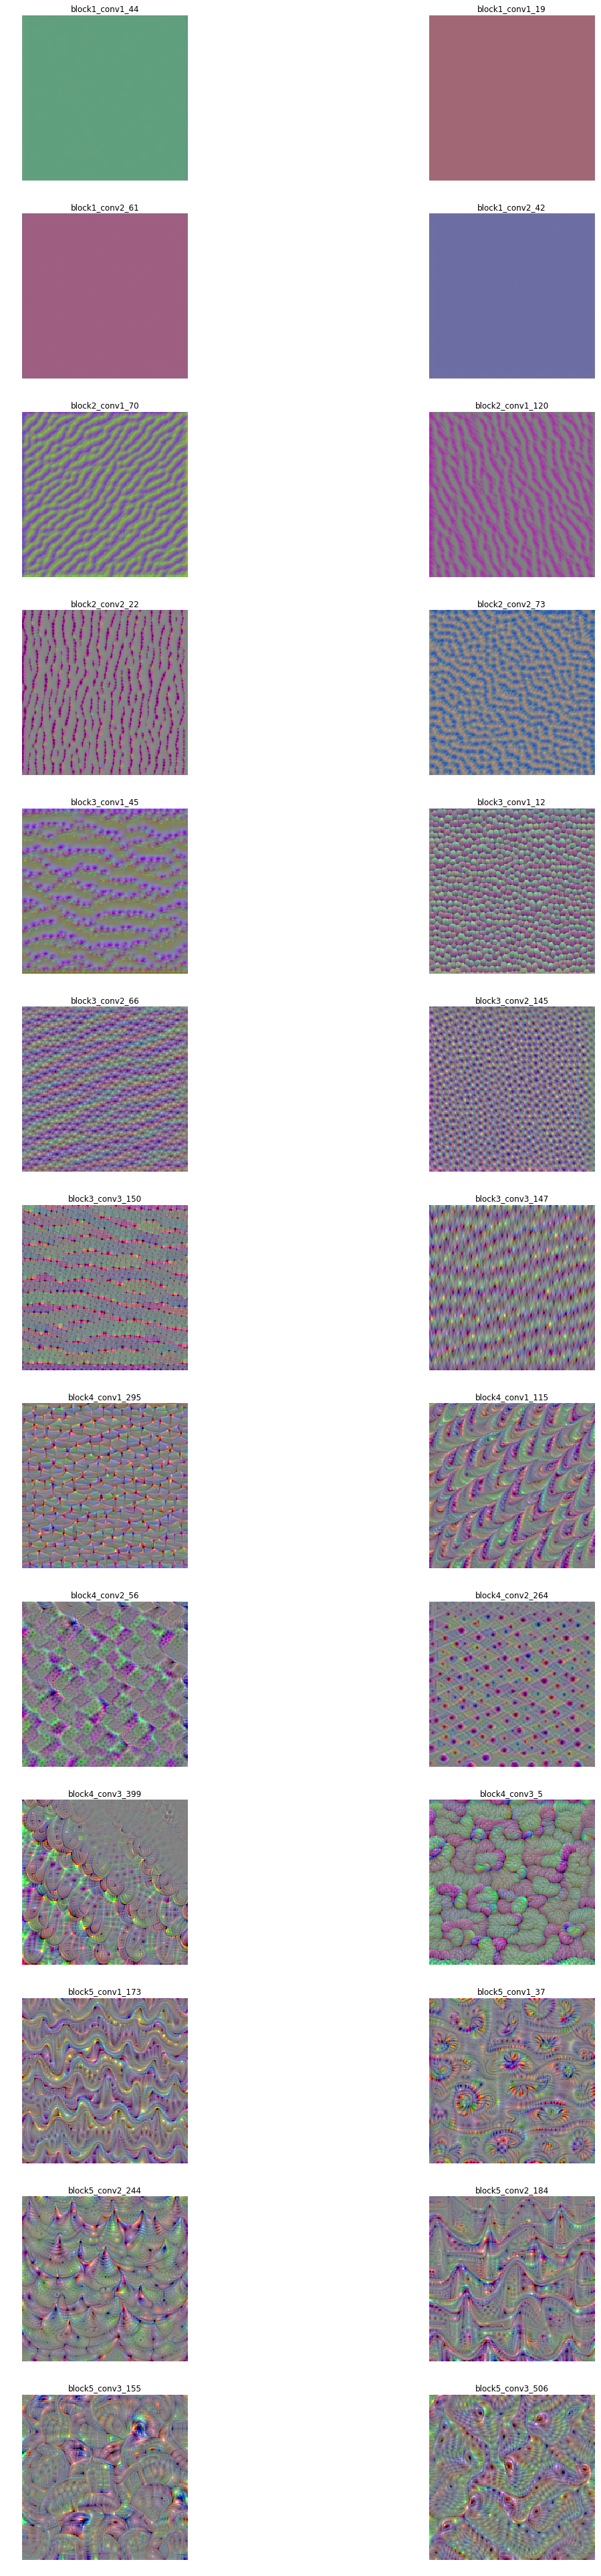

In [7]:
imshow(imgs, titles, figsize=(20, 70), n_cols=2)

### Exemples des 3 couches les plus profondes

In [ ]:
imgs = []
titles = []

block5_layers = [layer_name for layer_name in layers if "block5" in layer_name]

np.random.seed(0)

while len(imgs) < 10:
    layer_name = np.random.choice(block5_layers)
    filter_idx = np.random.randint(0, layer_dict[layer_name].output.shape.as_list()[-1] - 1)
    filter_name = f"{layer_name}_{filter_idx}"
    
    if filter_name in titles:
        continue

    print(f"#{len(imgs)} : {filter_name}")

    img, loss_value = optimize_filter_input(layer_name, filter_idx, iterations, step, sigma, decay)

    print(f"loss value = {loss_value:.2f}
    print()

    if loss_value > 0.:
        imgs.append(postprocess_noise(img))
        titles.append(filter_name)

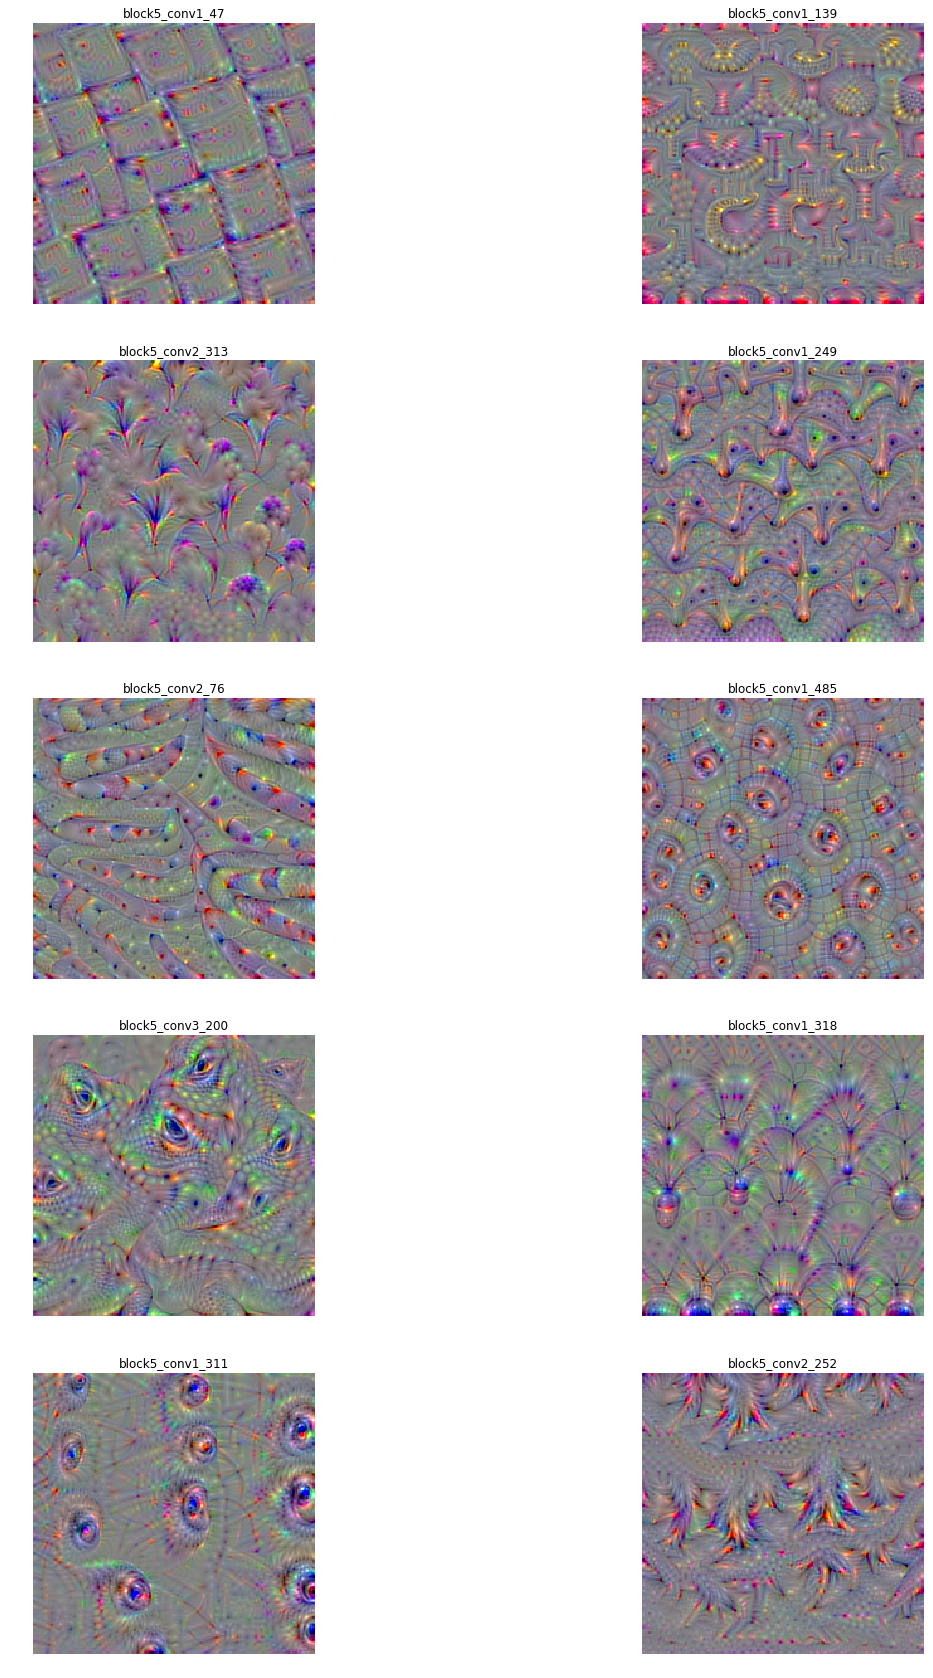

In [9]:
imshow(imgs, titles, figsize=(20, 30), n_cols=2)

## Optimisation pour une classe donnée

In [10]:
def get_pred_loss_and_grads_function(pred_index):
    loss = layer_dict["custom_predictions"].output[:, pred_index][0]
    # loss = loss - (0.005 * K.sum(K.square(dream)) / K.prod(K.cast(K.shape(dream), 'float32')))
    
    grads = K.gradients(loss, dream)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    return K.function([dream], [loss, grads])

In [11]:
iterations = 100
step = 10.
sigma = 3
decay = 0.9

In [ ]:
imgs = []
titles = []

np.random.seed(0)

while len(imgs) < 20:
    img = (np.random.random(img_shape) * 255).astype('uint8')
    img = preprocess_noise(img)

    pred_idx = np.random.randint(0, 1000)
    
    print(f"#{len(imgs)} : {pred_idx}")

    loss_and_grads_function = get_pred_loss_and_grads_function(pred_idx)

    for i in range(iterations):
        loss_value, grads_value = loss_and_grads_function([[img]])

        current_step = step - (i * (step / iterations))
        current_sigma = sigma - (i * (sigma / iterations))

        img += current_step * grads_value[0]
        
        img_blur = cv2.GaussianBlur(img, (3, 3), current_sigma)
        img_decay = img * decay
        img = (img_blur + img_decay) / 2
        img = img_blur

#         if i % 10 == 0 or i == iterations - 1:
#             print(f"loss value at {i} = {loss_value:.2f} (step = {current_step:.2f}, sigma = {current_sigma:.2f})")

    print(f"loss value = {loss_value:.2f}
    
    class_name = applications.vgg16.decode_predictions(model.predict([[img]]), top=1)[0][0][1]
    
    imgs.append(postprocess_noise(img))
    titles.append(f"{pred_idx} - {class_name}")    

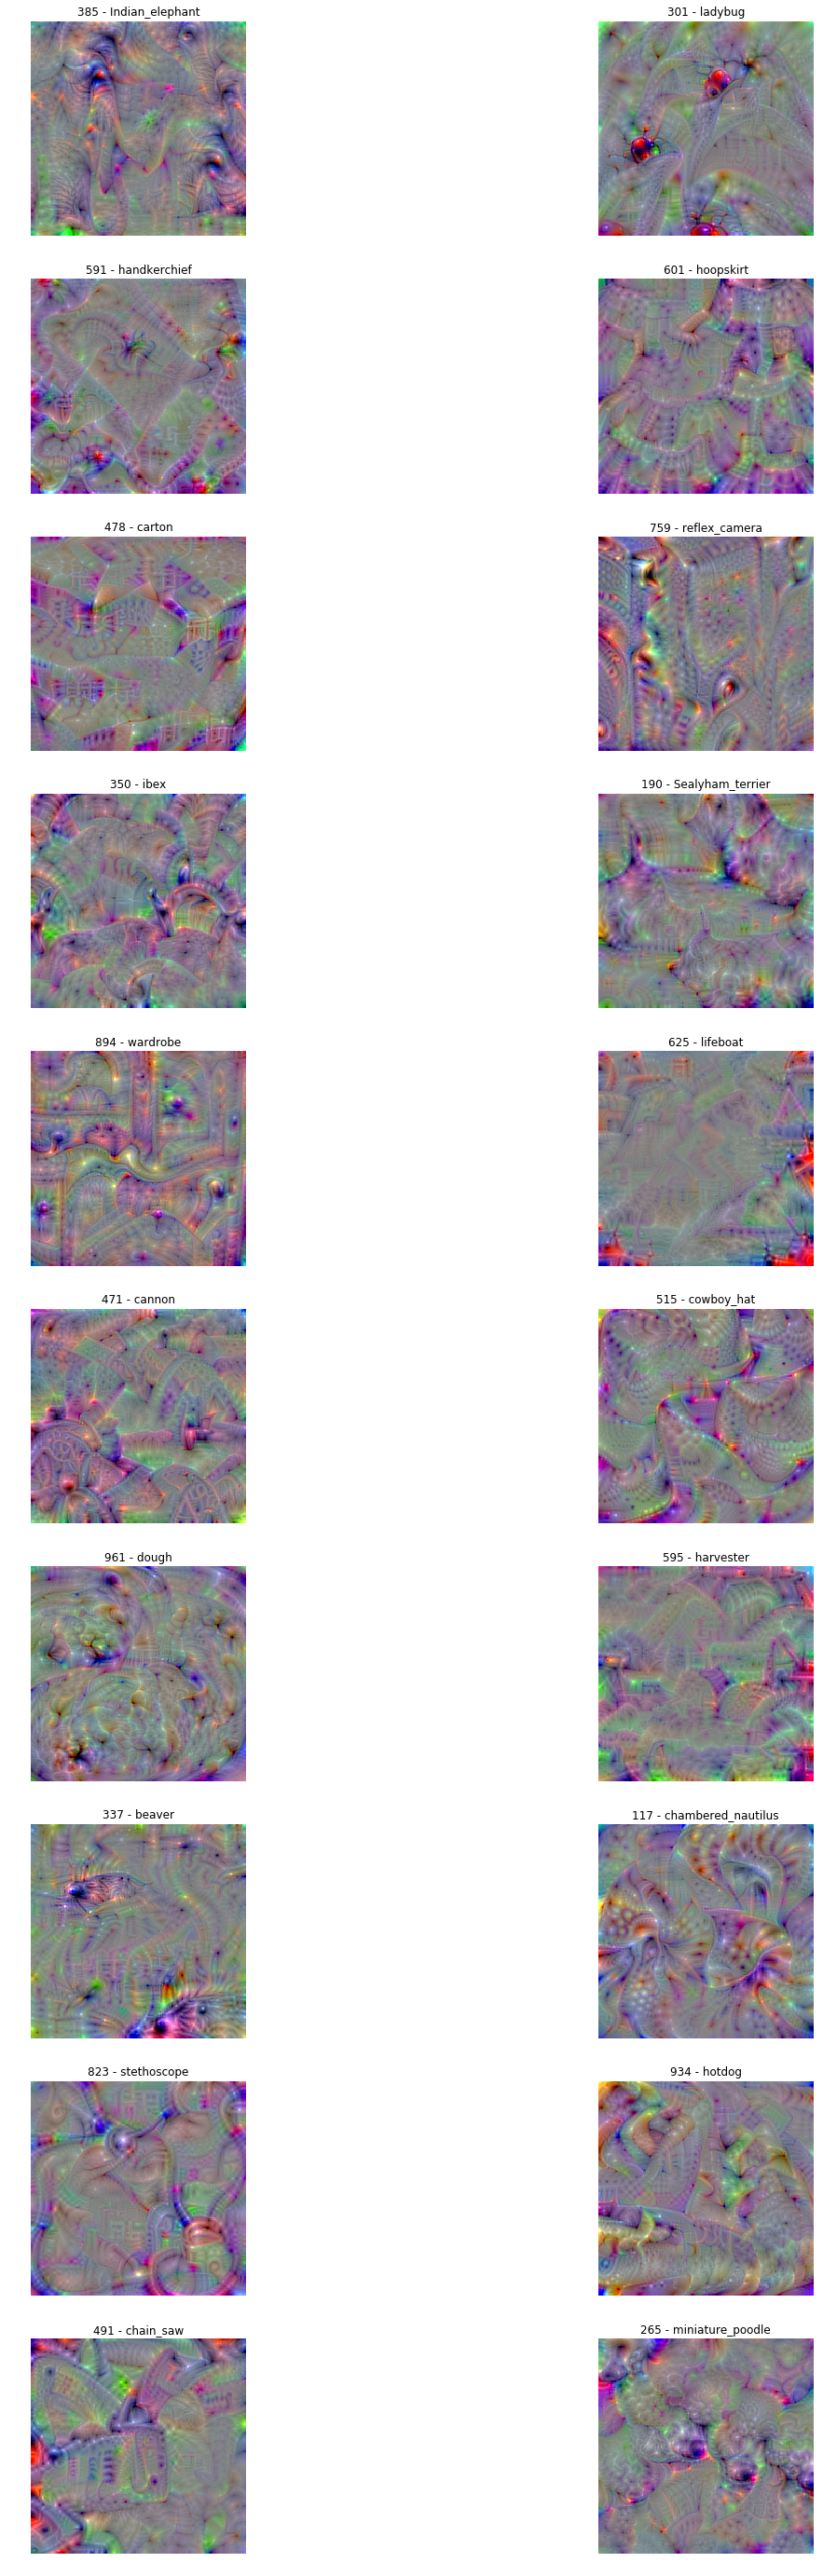

In [13]:
imshow(imgs, titles, figsize=(20, 50), n_cols=2)